# Tutorial: Computer CPU Evolution Analysis
CMU 15688 Spring 2021


### Setting up environment
https://drive.google.com/file/d/1ahobYKS66mL53KQhhMg8KoziKq74lToU/view?usp=sharing

In [134]:
import requests
import csv
import pandas as pd
import numpy as np
import scipy as sp
import scipy.optimize
from bs4 import BeautifulSoup
# import time
import re
import matplotlib.pyplot as plt
# import sklearn.linear_model
# import sklearn.pipeline
# import sklearn.preprocessing

In [15]:
!wget -q --show-progress 'https://drive.google.com/uc?export=download&id=1ahobYKS66mL53KQhhMg8KoziKq74lToU' -O Intel_CPUs.csv

Intel_CPUs.csv      100%[===================>] 557.62K  --.-KB/s    in 0.1s    


In [164]:
csv_file_name = 'Intel_CPUs.csv'
df = pd.read_csv(csv_file_name, header=0, sep=',', quotechar='"', dtype=str, keep_default_na=True)

### Preprocess

In [165]:
def search_string_to_float(input_value):
    if pd.isna(input_value):
        return float('nan')
    regex_process_node = re.compile('(\d+\.?\d*)')
    result = regex_process_node.search(input_value)
    if result == None:
        return float('nan')
    return float(result.group())

def search_freq_to_float(input_value):
    if pd.isna(input_value):
        return float('nan')
    regex_freq = re.compile('(\d+\.?\d*)\s?([MG]Hz)')
    result = regex_freq.search(input_value)
    if result == None:
        return float('nan')
    if result.group(2) == 'MHz':
        return float(result.group(1)) / 1000
    else:
        return float(result.group(1))

def search_price_to_float(input_value):
    if pd.isna(input_value):
        return float('nan')
    regex_price = re.compile('(\d*),?(\d+.?\d*)')
    result = regex_price.search(input_value)
    if result == None:
        return float('nan')
    return float(''.join([str(x) for x in result.groups()]))
    
def launch_date_to_datetime(input_value):
    if pd.isna(input_value):
        return float('nan')
    # some data is in the format of 04'16, should be Q4'16
    # like E5-2699AV4, it was released in Oct 2016
    # interestingly this is in fact a typo on Intel's offical site
    if input_value[0] == '0':
        input_value = 'Q' + input_value[1:]
    input_value = input_value.replace(' ', '')
    return pd.to_datetime('-'.join(input_value.split("'")[::-1]))

In [97]:
print(search_price_to_float('$1'))

('', '1')
1.0


In [166]:
df.dropna(subset=['Processor_Number', 'Launch_Date'], inplace=True)
df = df[~(df.Vertical_Segment == 'Server')]
df = df[~(df.Vertical_Segment == 'Embedded')]
df = df[~(df.Processor_Number.apply(lambda x: x.isnumeric()))]
df['Launch_Date'] = df['Launch_Date'].apply(lambda x: launch_date_to_datetime(x))
search_string_to_float_columns = [
    'Lithography',
#     'Recommended_Customer_Price',
    'nb_of_Cores',
    'nb_of_Threads',
    'TDP',
    'Instruction_Set'
]
search_freq_to_float_columns = [
    'Processor_Base_Frequency',
    'Max_Turbo_Frequency'
]
for column_name in search_string_to_float_columns:
    df[column_name] = df[column_name].apply(lambda x: search_string_to_float(x))  
for column_name in search_freq_to_float_columns:
    df[column_name] = df[column_name].apply(lambda x: search_freq_to_float(x))
df['Recommended_Customer_Price'] = df['Recommended_Customer_Price'].apply(lambda x: search_price_to_float(x))
df.reset_index(drop=True, inplace=True)
    
print('Done')
# print(df['Recommended_Customer_Price'].values)


Done


### Scraping CPU performance scores

In [167]:
def form_geekbench_url(cpu_name):
    query_url = 'https://browser.geekbench.com/v5/cpu/search?q='
    query_url += cpu_name
    return query_url

def parse_num_result(input_string):
    # remove ',' in numerical result
    input_string = input_string.replace(',', '')
    regex_num_result = re.compile('(\d+)')
    # should be a list of all numerical values in the input_string
    num_result_list = regex_num_result.search(input_string)
    return int(num_result_list.group())

def get_geekbench_score(cpu_series, cpu_name):
    if pd.isna(cpu_name):
        return tuple((float('nan'), float('nan')))
#     if cpu_name.isnumeric() and cpu_series.split()[0] == 'Legacy':
#         return tuple((float('nan'), float('nan')))
    query_url = form_geekbench_url(cpu_name)
    geekbench_response = requests.get(query_url)
    root = BeautifulSoup(geekbench_response.content, 'html.parser')
    
    num_result = parse_num_result(root.find('small').get_text())
    if num_result == 0:
        return tuple((float('nan'), float('nan')))
    # if less than five results, take the 1st one
    # else, take the average of first 5 results
#     if num_result < 5:
    found = False
    while True:
        for div in root.find_all('div', class_='col-12 list-col'):
            model_name = div.find_all('span', class_='list-col-model')[0].get_text()
#             print(model_name)
            if cpu_name in model_name:
                single_score_text = div.find_all('span', class_='list-col-subtitle-score', text='\nSingle-Core Score\n')[0]
                single_score_value = single_score_text.find_next_sibling('span', class_='list-col-text-score')
                multi_score_text = div.find_all('span', class_='list-col-subtitle-score', text='\nMulti-Core Score\n')[0]
                multi_score_value = multi_score_text.find_next_sibling('span', class_='list-col-text-score')
                return tuple((float(single_score_value.get_text()), float(multi_score_value.get_text())))
        return tuple((float('nan'), float('nan')))
#     else:
#         total_single_score = 0.0
#         total_multi_score = 0.0
#         for span in root.find_all('span', class_='list-col-subtitle-score', text='\nSingle-Core Score\n')[:5]:
#             single_score_value = span.find_next_sibling('span', class_='list-col-text-score')
#             total_single_score += float(single_score_value.get_text())
#         for span in root.find_all('span', class_='list-col-subtitle-score', text='\nMulti-Core Score\n')[:5]:
#             multi_score_value = span.find_next_sibling('span', class_='list-col-text-score')
#             total_multi_score += float(multi_score_value.get_text())
#         return tuple((total_single_score / 5, total_multi_score / 5))

In [163]:
print(get_geekbench_score('test', 'G460'))

(316.0, 383.0)


In [168]:
def scrap_geekbench(df):
    df_scrape = df.apply(lambda x: get_geekbench_score(x.Product_Collection, x.Processor_Number), axis=1)
    df_geekbench_scores = pd.DataFrame()
    df_geekbench_scores['Geekbench_Single'] = df_scrape.apply(lambda x: x[0])
    df_geekbench_scores['Geekbench_Multi'] = df_scrape.apply(lambda x: x[1])
    return df_geekbench_scores
df_geekbench_scores = scrap_geekbench(df)
df_geekbench_scores.to_csv('Intel_CPUs_only_geekbench_score.csv', encoding='utf-8', index=False)

In [143]:
csv_file_name = 'Intel_CPUs_only_geekbench_score.csv'
df_geekbench_scores = pd.read_csv(csv_file_name, header=0, sep=',', quotechar='"', dtype=str, keep_default_na=True)

In [309]:
df_with_score = df.join(df_geekbench_scores)
df_with_score.dropna(subset=['Geekbench_Single', 'Geekbench_Multi'], inplace=True)
df_with_score['Geekbench_Single'] = df_with_score['Geekbench_Single'].astype(float)
df_with_score['Geekbench_Multi'] = df_with_score['Geekbench_Multi'].astype(float)
df_with_score['Launch_Date'] = df_with_score['Launch_Date'].values.astype('datetime64[D]').astype(float)

In [170]:
df_with_score.to_csv('Intel_CPUs_with_score.csv', encoding='utf-8', index=False)

### Moore's Law

[8.55823200e+00 3.65635623e-04]
[1.00337353e+01 3.78635094e-04]
[7.16679082e+00 4.65313283e-04]
[1.04055517e+00 6.85740334e-04]


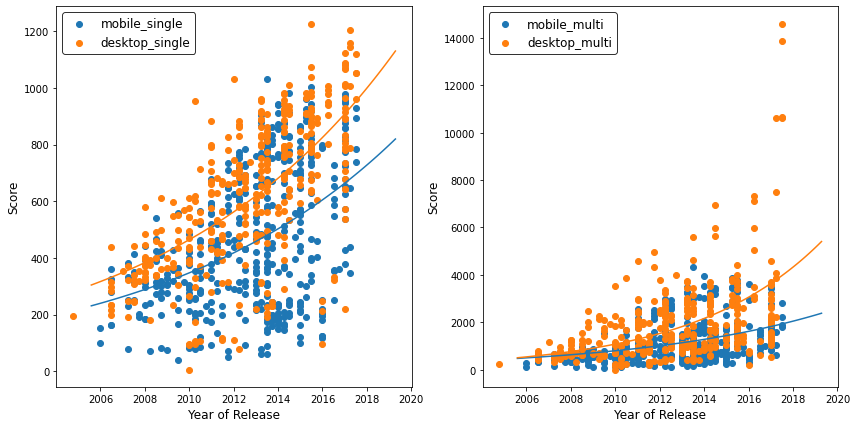

In [310]:
def power(x, a, b):
    return a * np.power(2, b*x)

df_desktop = df_with_score[df_with_score.Vertical_Segment == 'Desktop']
df_mobile = df_with_score[df_with_score.Vertical_Segment == 'Mobile']

mobile_launch_time = pd.to_datetime(df_mobile['Launch_Date'], unit='D')
mobile_single_core_perf = df_mobile['Geekbench_Single'].values
mobile_multi_core_perf = df_mobile['Geekbench_Multi'].values

desktop_launch_time = pd.to_datetime(df_desktop['Launch_Date'], unit='D')
desktop_single_core_perf = df_desktop['Geekbench_Single'].values
desktop_multi_core_perf = df_desktop['Geekbench_Multi'].values

mobile_X = df_mobile['Launch_Date'].values
mobile_X = np.asarray([x.astype(float) for x in mobile_X])
mobile_y = df_mobile['Geekbench_Single'].values
mobile_model, _ = sp.optimize.curve_fit(f=power, xdata=mobile_X, ydata=mobile_y, p0=[0, 0]) 
print(mobile_model)

desktop_X = df_desktop['Launch_Date'].values
desktop_X = np.asarray([x.astype(float) for x in desktop_X])
desktop_y = df_desktop['Geekbench_Single'].values
desktop_model, _ = sp.optimize.curve_fit(f=power, xdata=desktop_X, ydata=desktop_y, p0=[0, 0]) 
print(desktop_model)

mobile_y_multi = df_mobile['Geekbench_Multi'].values
mobile_model_multi, _ = sp.optimize.curve_fit(f=power, xdata=mobile_X, ydata=mobile_y_multi, p0=[0, 0]) 
print(mobile_model_multi)

desktop_y_multi = df_desktop['Geekbench_Multi'].values
desktop_model_multi, _ = sp.optimize.curve_fit(f=power, xdata=desktop_X, ydata=desktop_y_multi, p0=[0, 0]) 
print(desktop_model_multi)

plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.scatter(mobile_launch_time, mobile_single_core_perf, label='mobile_single', c='tab:blue')
plt.scatter(desktop_launch_time, desktop_single_core_perf, label='desktop_single', c='tab:orange')
plt.legend(loc=2, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")
plt.xlabel('Year of Release', fontsize=12)
plt.ylabel('Score', fontsize=12)

# from around 2005 to 2019, in #days
x_fit = np.linspace(13000, 18000, 100)
plt.plot(x_fit, power(x_fit, mobile_model[0], mobile_model[1]))
plt.plot(x_fit, power(x_fit, desktop_model[0], desktop_model[1]))


plt.subplot(1, 2, 2)
plt.scatter(mobile_launch_time, mobile_multi_core_perf, label='mobile_multi', c='tab:blue')
plt.scatter(desktop_launch_time, desktop_multi_core_perf, label='desktop_multi', c='tab:orange')
plt.legend(loc=2, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")
plt.xlabel('Year of Release', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.plot(x_fit, power(x_fit, mobile_model_multi[0], mobile_model_multi[1]))
plt.plot(x_fit, power(x_fit, desktop_model_multi[0], desktop_model_multi[1]))
plt.show()

In [311]:
print(desktop_model[1] * 365)
print(desktop_model_multi[1] * 365)
print(mobile_model[1] * 365)
print(mobile_model_multi[1] * 365)

0.13820180919136255
0.2502952220250091
0.13345700234672306
0.16983934829063707


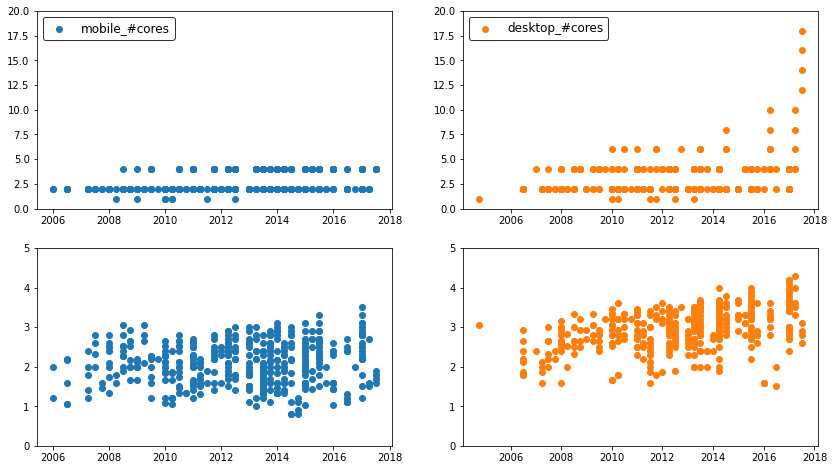

In [312]:
plt.figure(figsize=(14,8))
plt.subplot(2, 2, 1)
mobile_core_num = df_mobile['nb_of_Cores'].values

plt.scatter(mobile_launch_time, mobile_core_num, label='mobile_#cores', c='tab:blue')
plt.ylim((0, 20))
plt.legend(loc=2, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")

plt.subplot(2, 2, 2)
desktop_core_num = df_desktop['nb_of_Cores'].values
plt.scatter(desktop_launch_time, desktop_core_num, label='desktop_#cores', c='tab:orange')
plt.ylim((0, 20))
plt.legend(loc=2, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")

plt.subplot(2, 2, 3)
mobile_freq = df_mobile['Processor_Base_Frequency'].values
plt.scatter(mobile_launch_time, mobile_freq, label='mobile_base_freq', c='tab:blue')
plt.ylim((0, 5))

plt.subplot(2, 2, 4)
desktop_freq = df_desktop['Processor_Base_Frequency'].values
plt.scatter(desktop_launch_time, desktop_freq, label='desktop_base_freq', c='tab:orange')
plt.ylim((0, 5))

plt.show()

https://ark.intel.com/content/www/us/en/ark/products/series/77772/intel-pentium-processor-g-series.html#@Desktop
https://ark.intel.com/content/www/us/en/ark/products/series/90613/intel-celeron-processor-g-series.html#@Desktop

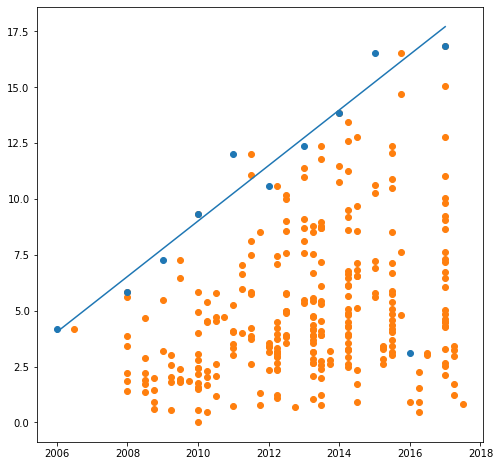

In [313]:
def linear(x, a, b):
    return a * x + b

df_with_score_price = df_with_score.dropna(subset=['Recommended_Customer_Price'])
df_desktop = df_with_score_price[df_with_score_price.Vertical_Segment == 'Desktop']
df_mobile = df_with_score_price[df_with_score_price.Vertical_Segment == 'Mobile']

mobile_launch_time = pd.to_datetime(df_mobile['Launch_Date'], unit='D')
desktop_launch_time = pd.to_datetime(df_desktop['Launch_Date'], unit='D')

df_desktop_perf_per_dollar = pd.DataFrame()
df_desktop_perf_per_dollar['Single_Perf_Per_Dollar'] = df_desktop.apply(lambda x: x.Geekbench_Single / x.Recommended_Customer_Price, axis=1)
df_desktop_perf_per_dollar['Multi_Perf_Per_Dollar'] = df_desktop.apply(lambda x: x.Geekbench_Multi / x.Recommended_Customer_Price, axis=1)
df_desktop = df_desktop.join(df_desktop_perf_per_dollar)


launch_years = pd.to_datetime(df_desktop['Launch_Date'], unit='D').apply(lambda x: x.year).values
launch_years = list(set(launch_years))
launch_years.sort()

max_all_years = []
for launch_year in launch_years:
    df_per_year = df_desktop[pd.to_datetime(df_desktop['Launch_Date'], unit='D').apply(lambda x: x.year).values == launch_year]
    max_per_year = df_per_year['Single_Perf_Per_Dollar'].max()
    max_all_years.append(max_per_year)
launch_years = [pd.to_datetime(x, format='%Y') for x in launch_years]
launch_years = [x.to_datetime64().astype('datetime64[D]').astype(float) for x in launch_years]  
    
desktop_model, _ = sp.optimize.curve_fit(f=linear, xdata=launch_years, ydata=max_all_years, p0=[0, 0])


x_fit = np.linspace(13000, 18000, 100)
launch_years = np.asarray(launch_years)


plt.figure(figsize=(8,8))
plt.scatter(desktop_launch_time, df_desktop['Single_Perf_Per_Dollar'].values, c='tab:orange')
plt.scatter(launch_years, max_all_years)
# plt.plot(launch_years, linear(launch_years, desktop_model[0], desktop_model[1]), c='tab:orange')
launch_years = np.delete(launch_years, -2)
max_all_years = np.delete(max_all_years, -2)
desktop_model, _ = sp.optimize.curve_fit(f=linear, xdata=launch_years, ydata=max_all_years, p0=[0, 0]) 
plt.plot(launch_years, linear(launch_years, desktop_model[0], desktop_model[1]), c='tab:blue')
plt.show()




In [314]:
df_desktop['Launch_Date'] = df_desktop['Launch_Date'].apply(lambda x: pd.to_datetime(x, unit='D').year)
df_desktop_single_sorted = df_desktop.sort_values(by=['Single_Perf_Per_Dollar'], ascending=False)
print_list = [
    'Product_Collection',
    'Vertical_Segment',
    'Processor_Number',
    'Launch_Date',
    'Recommended_Customer_Price',
    'Geekbench_Single',
    'Single_Perf_Per_Dollar'
]
df_desktop_single_sorted.head(10)[print_list]

,Product_Collection,Vertical_Segment,Processor_Number,Launch_Date,Recommended_Customer_Price,Geekbench_Single,Single_Perf_Per_Dollar
114,Intel® Celeron® Processor G Series,Desktop,G3930,2017,42.0,708.0,16.857143
111,Intel® Celeron® Processor G Series,Desktop,G3900,2015,42.0,694.0,16.523810
781,Intel® Pentium® Processor G Series,Desktop,G4560,2017,64.0,964.0,15.062500
113,Intel® Celeron® Processor G Series,Desktop,G3920,2015,52.0,764.0,14.692308
106,Intel® Celeron® Processor G Series,Desktop,G1820T,2014,42.0,581.0,13.833333
108,Intel® Celeron® Processor G Series,Desktop,G1840,2014,42.0,564.0,13.428571
793,Intel® Pentium® Processor G Series,Desktop,G3250,2014,50.0,639.0,12.780000
116,Intel® Celeron® Processor G Series,Desktop,G3930T,2017,42.0,536.0,12.761905
790,Intel® Pentium® Processor G Series,Desktop,G3240,2014,54.0,680.0,12.592593
783,Intel® Pentium® Processor G Series,Desktop,G4500,2015,75.0,928.0,12.373333
